# Downloading and Extracting the Dataset

In [1]:
!wget https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz

--2022-10-07 21:16:30--  https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz
Resolving zenodo.org (zenodo.org)... 188.184.117.155
Connecting to zenodo.org (zenodo.org)|188.184.117.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6023741708 (5.6G) [application/octet-stream]
Saving to: ‘UrbanSound8K.tar.gz’

UrbanSound8K.tar.gz 100%[===================>]   5.61G  26.3MB/s    in 3m 43s  

2022-10-07 21:20:14 (25.8 MB/s) - ‘UrbanSound8K.tar.gz’ saved [6023741708/6023741708]



In [2]:
!tar -xf UrbanSound8K.tar.gz

# Imports

In [2]:
import os
import random
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import librosa
import librosa.display
import cv2 as cv
import tensorflow as tf

# Creating Spectrograms

In [4]:
def create_spectrogram(y):
    spec = librosa.feature.melspectrogram(y=y)
    spec_conv = librosa.amplitude_to_db(spec, ref=np.max)
    return spec_conv


def save_spectrogram(spectrogram, file_name, classid):
    if str(classid) not in os.listdir("spectrograms"):
        os.mkdir(f"spectrograms/{classid}")

    save_name = file_name.split(".")[0]
    
    plt.figure()
    librosa.display.specshow(spectrogram)
    plt.savefig(f"spectrograms/{classid}/{save_name}.png", bbox_inches="tight", pad_inches=0)
    plt.close()

In [5]:
df = pd.read_csv("UrbanSound8K/metadata/UrbanSound8K.csv")
df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [ ]:
path_to_folds = "UrbanSound8K/audio"

if "spectrograms" not in os.listdir():
    os.mkdir("spectrograms")

number_of_files = df.shape[0]
number_of_processed = 0
number_of_errors = 0


with open("errors.txt", "w") as error_file:
    for index, row in df.iterrows():
        try:
            file_name = row["slice_file_name"]
            fold = row["fold"]
            classid = row["classID"]
            path_to_file = f"{path_to_folds}/fold{fold}/{file_name}"
                        
            data, sr = librosa.load(path_to_file)
            spectrogram = create_spectrogram(data)
            save_spectrogram(spectrogram, file_name, classid)
            
            del data
            del sr
            del spectrogram
            
        except Exception as e:
            number_of_errors += 1
            error_file.write(f"{number_of_errors}: {e}\n")
        
        finally:
            number_of_processed += 1
        
        print(f"\rNumber: {number_of_processed}/{number_of_files} | Errors: {number_of_errors}", end="")

Number: 3556/8732 | Errors: 0

/opt/conda/lib/python3.7/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1323
  return f(*args, **kwargs)


Number: 7867/8732 | Errors: 0

# Preprocessing

In [3]:
images = []
number_of_errors = 0
number_of_processed = 0

for classid in os.listdir("spectrograms"):
    path_to_class = f"spectrograms/{classid}"
    for image in os.listdir(path_to_class):
        try:
            path_to_image = f"{path_to_class}/{image}"
            
            img = cv.imread(path_to_image, 0)
            img = cv.resize(img, (128,128))
            img = img/255
            images.append([img, int(classid)])
            number_of_processed += 1

        except:
            number_of_errors += 1
        
        print(f"\rProcessed: {number_of_processed} | Erros: {number_of_errors}", end="")

Processed: 7867 | Erros: 0

In [4]:
len(images)

7867

In [5]:
for _ in range(10):
    random.shuffle(images)

In [6]:
X = []
y = []

for image, idx in images:
    X.append(image)
    y.append(idx)

In [7]:
X_train = []
y_train = []

X_val = []
y_val = []

X_test = []
y_test = []

In [8]:
X_train = X[:6293]
y_train = y[:6293]

X_val = X[6293:7079]
y_val = y[6293:7079]

X_test = X[7079:]
y_test = y[7079:]

In [9]:
print(len(X_train))
print(len(y_train))
print(len(X_val))
print(len(y_val))
print(len(X_test))
print(len(y_test))

6293
6293
786
786
788
788


In [10]:
X_train = np.array(X_train)
y_train = np.array(y_train)

X_val = np.array(X_val)
y_val = np.array(y_val)

X_test = np.array(X_test)
y_test = np.array(y_test)

In [11]:
X_train = X_train.reshape(-1, 128, 128, 1) 
X_val = X_val.reshape(-1, 128, 128, 1) 
X_test = X_test.reshape(-1, 128, 128, 1) 

In [12]:
if "pickles" not in os.listdir():
    os.mkdir("pickles")

with open("pickles/X_train.pickle", "wb") as f:
  pickle.dump(X_train, f)  
with open("pickles/y_train.pickle", "wb") as f:
  pickle.dump(y_train, f)

with open("pickles/X_val.pickle", "wb") as f:
  pickle.dump(X_val, f)  
with open("pickles/y_val.pickle", "wb") as f:
  pickle.dump(y_val, f)

with open("pickles/X_test.pickle", "wb") as f:
  pickle.dump(X_test, f)  
with open("pickles/y_test.pickle", "wb") as f:
  pickle.dump(y_test, f)

# Model Training

In [13]:
# Model
model = tf.keras.Sequential()

# Feature Extraction
model.add(tf.keras.layers.Conv2D(32, kernel_size=(3,3), strides=(2,2), padding="same", input_shape=(128, 128, 1)))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)))

model.add(tf.keras.layers.Conv2D(32, kernel_size=(3,3), strides=(2,2), padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(tf.keras.layers.Conv2D(32, kernel_size=(3,3), strides=(2,2), padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)))

# Flatten
model.add(tf.keras.layers.Flatten())

# Classification
model.add(tf.keras.layers.Dense(64, activation="relu"))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(64, activation="relu"))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(64, activation="relu"))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(64, activation="relu"))
model.add(tf.keras.layers.Dropout(0.5))

# Output Layer
model.add(tf.keras.layers.Dense(10, activation="softmax"))

2022-10-07 22:06:38.477036: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [14]:
model.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=['accuracy'])

In [15]:
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val))

2022-10-07 22:09:01.104807: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50
197/197 [==============================] - 5s 21ms/step - loss: 2.2474 - accuracy: 0.1370 - val_loss: 2.1117 - val_accuracy: 0.2506
Epoch 2/50
197/197 [==============================] - 4s 20ms/step - loss: 2.0874 - accuracy: 0.2452 - val_loss: 1.9756 - val_accuracy: 0.2710
Epoch 3/50
197/197 [==============================] - 5s 24ms/step - loss: 1.9612 - accuracy: 0.2733 - val_loss: 1.8670 - val_accuracy: 0.3321
Epoch 4/50
197/197 [==============================] - 4s 19ms/step - loss: 1.8823 - accuracy: 0.2838 - val_loss: 1.7050 - val_accuracy: 0.3588
Epoch 5/50
197/197 [==============================] - 4s 19ms/step - loss: 1.7849 - accuracy: 0.3008 - val_loss: 1.6471 - val_accuracy: 0.3486
Epoch 6/50
197/197 [==============================] - 4s 20ms/step - loss: 1.7180 - accuracy: 0.3076 - val_loss: 1.6073 - val_accuracy: 0.3664
Epoch 7/50
197/197 [==============================] - 4s 20ms/step - loss: 1.6688 - accuracy: 0.3123 - val_loss: 1.5221 - val_accuracy: 0.3677

In [16]:
result = model.evaluate(X_test, y_test)
print(f"Loss: {result[0]} - Accuracy: {result[1]}")

25/25 [==============================] - 0s 9ms/step - loss: 0.9643 - accuracy: 0.6954
Loss: 0.9643204808235168 - Accuracy: 0.6954314708709717


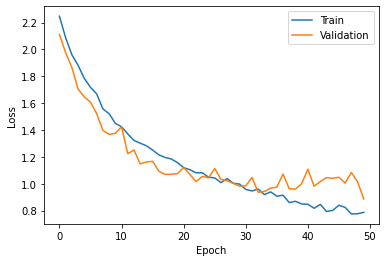

In [17]:
plt.plot(history.history["loss"], label="Train")
plt.plot(history.history["val_loss"], label="Validation")

plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.legend()
plt.show()

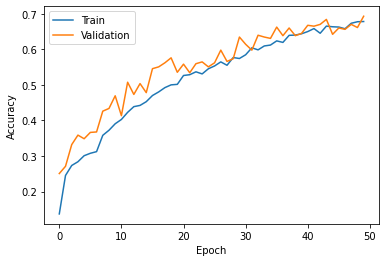

In [18]:
plt.plot(history.history["accuracy"], label="Train")
plt.plot(history.history["val_accuracy"], label="Validation")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.legend()
plt.show()